In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import display
from statsmodels import api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from toms_custom_functions import factorize_objects, create_dummies

''' Read in and examine data '''

# Set option to display all df columns
pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore")

# Replace path with your own directory to re-run
my_path = "/Users/thomasfleming/Desktop/machine_learning"

# Read in mock dataset
df = pd.read_csv(f"{my_path}/Credit Card Defaulter Prediction.csv")

# View head of dataset, non-null count, and dtypes
display(df.head())
display(df.info())

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,F,University,Married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,Y
1,2,120000,F,University,Single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,Y
2,3,90000,F,University,Single,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,N
3,4,50000,F,University,Married,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,N
4,5,50000,M,University,Married,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,N


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         30000 non-null  int64 
 1   LIMIT_BAL  30000 non-null  int64 
 2   SEX        30000 non-null  object
 3   EDUCATION  30000 non-null  object
 4   MARRIAGE   30000 non-null  object
 5   AGE        30000 non-null  int64 
 6   PAY_0      30000 non-null  int64 
 7   PAY_2      30000 non-null  int64 
 8   PAY_3      30000 non-null  int64 
 9   PAY_4      30000 non-null  int64 
 10  PAY_5      30000 non-null  int64 
 11  PAY_6      30000 non-null  int64 
 12  BILL_AMT1  30000 non-null  int64 
 13  BILL_AMT2  30000 non-null  int64 
 14  BILL_AMT3  30000 non-null  int64 
 15  BILL_AMT4  30000 non-null  int64 
 16  BILL_AMT5  30000 non-null  int64 
 17  BILL_AMT6  30000 non-null  int64 
 18  PAY_AMT1   30000 non-null  int64 
 19  PAY_AMT2   30000 non-null  int64 
 20  PAY_AMT3   30000 non-null  i

None

In [135]:
''' See value counts for object variables '''
print(df["SEX"].value_counts())
print(df["EDUCATION"].value_counts())
print(df["MARRIAGE"].value_counts())

F    18112
M    11888
Name: SEX, dtype: int64
University         14030
Graduate school    10585
High School         4917
Unknown              331
Others               123
0                     14
Name: EDUCATION, dtype: int64
Single     15964
Married    13659
Other        323
0             54
Name: MARRIAGE, dtype: int64


In [136]:
''' Make changes to variables in df '''

# Drop ID, as we already have an index
df.drop(columns=["ID"], inplace=True)

# Eliminate whitespace in any columns and convert to lower case
df.rename(str.strip, axis="columns", inplace=True)
df.rename(str.lower, axis="columns", inplace=True)

# Drop rows with Unknown, Other, and 0 for Education or Marriage
df = df[~df.education.isin(["Unknown", "Others", "0"])]
df = df[~df.marriage.isin(["Other", "0"])]

# Factorize education, ordering by level
df["education"].replace("High School", "1_high_school", inplace=True)
df["education"].replace("University", "2_university", inplace=True)
df["education"].replace("Graduate school", "3_grad_school", inplace=True)
codes, uniques = pd.factorize(df["education"], sort=True)
print(f"Codes: {codes}")
print(f"Unique values: {uniques}")
df["education"] = codes

# Turn sex, education, and marriage into dummies
create_dummies(df, "sex", "sex")
create_dummies(df, "marriage", "marriage")

# Turn default into a factor
factorize_objects(df)
print(df.info())

Codes: [1 1 1 ... 1 0 1]
Unique values: Index(['1_high_school', '2_university', '3_grad_school'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29163 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   limit_bal        29163 non-null  int64
 1   education        29163 non-null  int64
 2   age              29163 non-null  int64
 3   pay_0            29163 non-null  int64
 4   pay_2            29163 non-null  int64
 5   pay_3            29163 non-null  int64
 6   pay_4            29163 non-null  int64
 7   pay_5            29163 non-null  int64
 8   pay_6            29163 non-null  int64
 9   bill_amt1        29163 non-null  int64
 10  bill_amt2        29163 non-null  int64
 11  bill_amt3        29163 non-null  int64
 12  bill_amt4        29163 non-null  int64
 13  bill_amt5        29163 non-null  int64
 14  bill_amt6        29163 non-null  int64
 15  pay_amt1         29163 n

In [137]:
''' Get response, training, and test datasets and set initial baseline  '''

# Set y to ChargeOff_Flag, since there are more charge-offs than late-stage delinquencies
y = df["default"]

# Assumption Check #1: View response variable values in order to select appropriate logistic regression model
print(f"Unique values in response variable: {y.unique()}")
print("\n")

# Set predictor matrix to include all fields except response variable
X = df.loc[:, ~df.columns.isin(["default"])]

# Divide X and y into training and test sets and fit the initial model
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

X_cnst = sm.add_constant(X_train.dropna())

lm_cnt = sm.GLM(y_train[X_cnst.index.values], X_cnst, family=sm.families.Binomial(), missing="drop").fit()

print(lm_cnt.summary())

Unique values in response variable: [0 1]


                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                23330
Model:                            GLM   Df Residuals:                    23306
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10898.
Date:                Mon, 24 Oct 2022   Deviance:                       21795.
Time:                        22:56:18   Pearson chi2:                 2.96e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

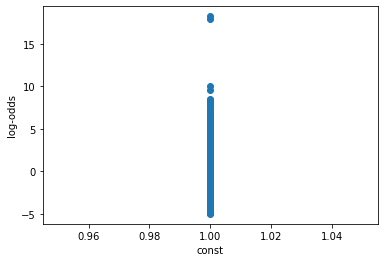

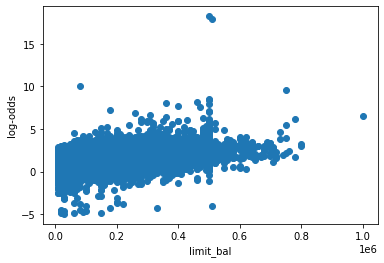

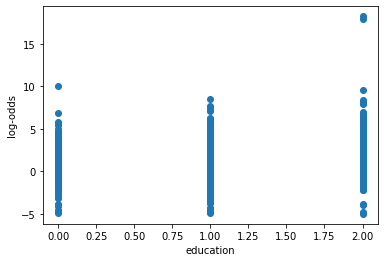

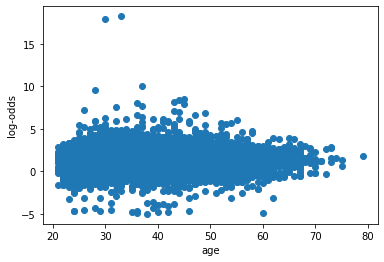

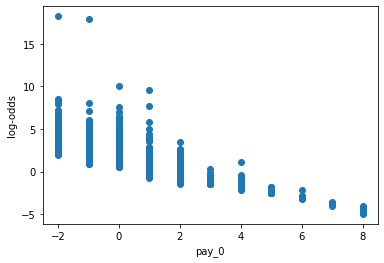

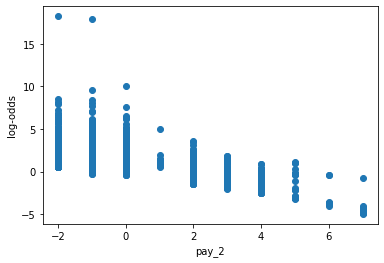

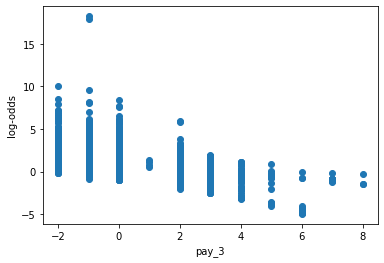

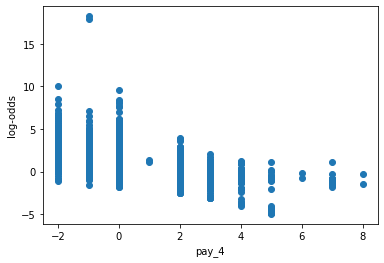

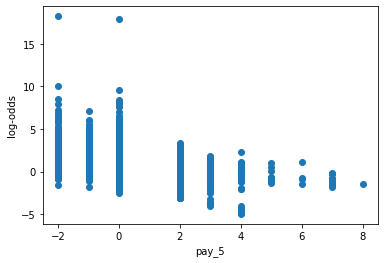

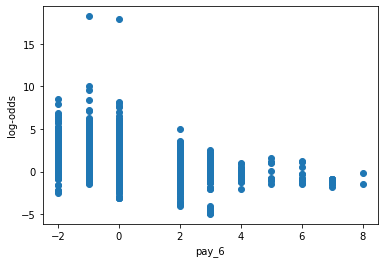

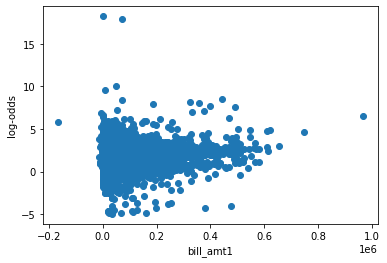

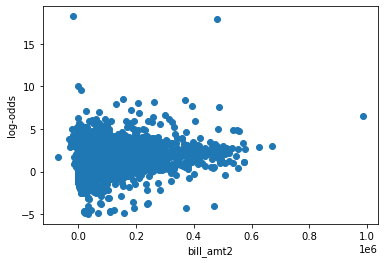

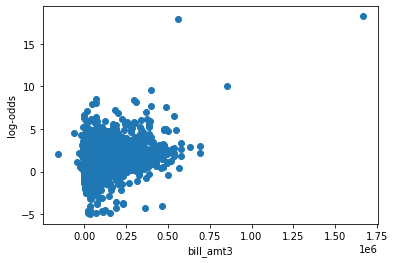

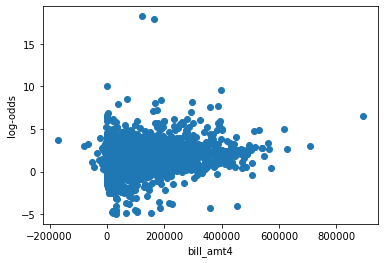

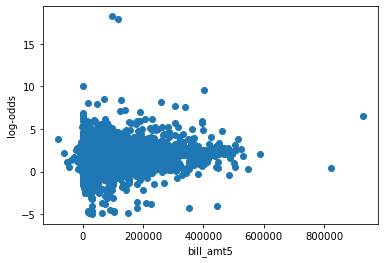

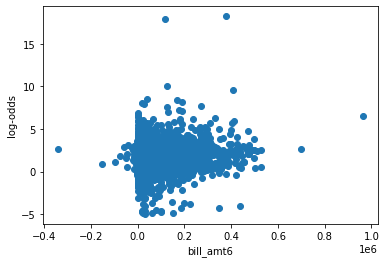

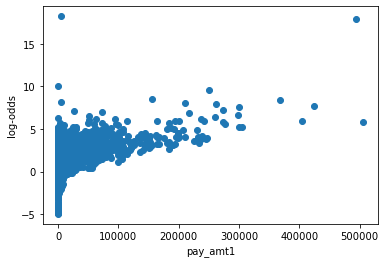

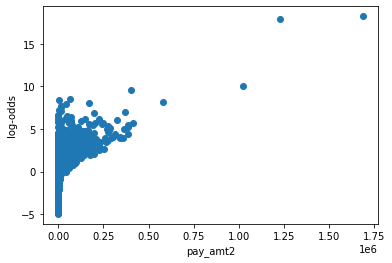

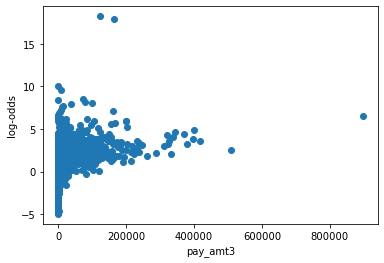

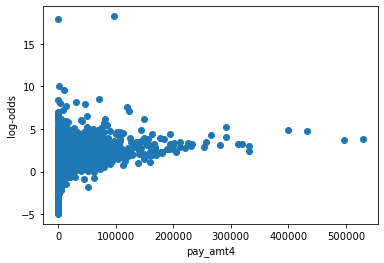

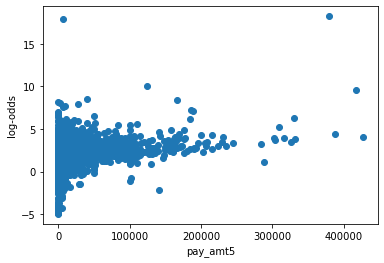

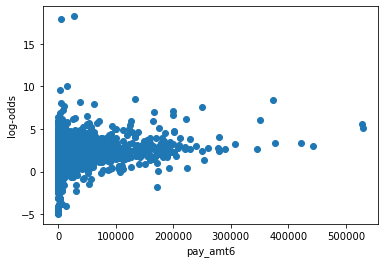

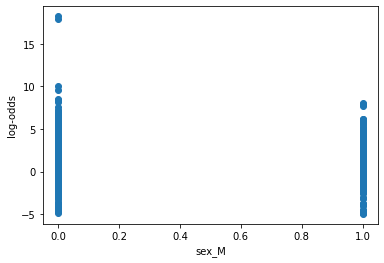

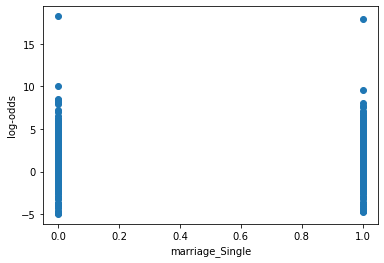

In [138]:
''' 
Assumption Check #2: Visualize predictor variable versus log-odds to check for non-linear relationship
between logit and predictor variables
'''

X_cnst = sm.add_constant(X_train)
# Fit model and get predicted y values
lm_num = sm.GLM(y_train, X_cnst, family=sm.families.Binomial(), missing="drop").fit()
predicted = lm_num.predict(X_cnst)

# Calculated log-odds and add it to X_num
log_odds = np.log(predicted / (1 - predicted))

# Create plots of each predictor vs. log-odds
for var in X_cnst.columns.values:
    plt.scatter(x=X_cnst[var].values, y=log_odds)
    plt.xlabel(var)
    plt.ylabel("log-odds")
    plt.show()

In [139]:
''' Log the non-linear variables '''

for var in X_train.filter(like='pay_amt').columns.tolist():
    X_train[var].replace(0, np.nan, inplace=True)
    X_train[f"log_{var}"] = np.log(X_train[var])
    X_train.drop(columns=[var], inplace=True)

for var in X_train.filter(like='bill_amt').columns.tolist():
    X_train[var].replace(0, np.nan, inplace=True)
    X_train[f"log_{var}"] = np.log(X_train[var])
    X_train.drop(columns=[var], inplace=True)
    
X_train["limit_bal"].replace(0, np.nan, inplace=True)
X_train[f"log_limit_bal"] = np.log(X_train["limit_bal"])
X_train.drop(columns=["limit_bal"], inplace=True)
    
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23330 entries, 23289 to 14157
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   education        23330 non-null  int64  
 1   age              23330 non-null  int64  
 2   pay_0            23330 non-null  int64  
 3   pay_2            23330 non-null  int64  
 4   pay_3            23330 non-null  int64  
 5   pay_4            23330 non-null  int64  
 6   pay_5            23330 non-null  int64  
 7   pay_6            23330 non-null  int64  
 8   sex_M            23330 non-null  uint8  
 9   marriage_Single  23330 non-null  uint8  
 10  log_pay_amt1     19199 non-null  float64
 11  log_pay_amt2     19094 non-null  float64
 12  log_pay_amt3     18641 non-null  float64
 13  log_pay_amt4     18341 non-null  float64
 14  log_pay_amt5     18146 non-null  float64
 15  log_pay_amt6     17790 non-null  float64
 16  log_bill_amt1    21327 non-null  float64
 17  log_bill

In [140]:
''' Log the non-linear variables '''

for var in X_test.filter(like='pay_amt').columns.tolist():
    X_test[var].replace(0, np.nan, inplace=True)
    X_test[f"log_{var}"] = np.log(X_test[var])
    X_test.drop(columns=[var], inplace=True)

for var in X_test.filter(like='bill_amt').columns.tolist():
    X_test[var].replace(0, np.nan, inplace=True)
    X_test[f"log_{var}"] = np.log(X_test[var])
    X_test.drop(columns=[var], inplace=True)
    
X_test["limit_bal"].replace(0, np.nan, inplace=True)
X_test[f"log_limit_bal"] = np.log(X_test["limit_bal"])
X_test.drop(columns=["limit_bal"], inplace=True)
    
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5833 entries, 18966 to 18373
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   education        5833 non-null   int64  
 1   age              5833 non-null   int64  
 2   pay_0            5833 non-null   int64  
 3   pay_2            5833 non-null   int64  
 4   pay_3            5833 non-null   int64  
 5   pay_4            5833 non-null   int64  
 6   pay_5            5833 non-null   int64  
 7   pay_6            5833 non-null   int64  
 8   sex_M            5833 non-null   uint8  
 9   marriage_Single  5833 non-null   uint8  
 10  log_pay_amt1     4840 non-null   float64
 11  log_pay_amt2     4806 non-null   float64
 12  log_pay_amt3     4720 non-null   float64
 13  log_pay_amt4     4590 non-null   float64
 14  log_pay_amt5     4527 non-null   float64
 15  log_pay_amt6     4438 non-null   float64
 16  log_bill_amt1    5305 non-null   float64
 17  log_bill_

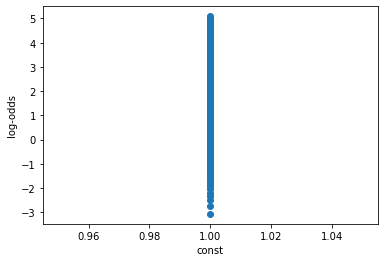

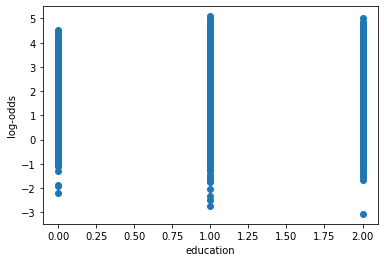

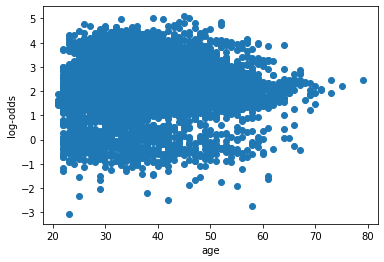

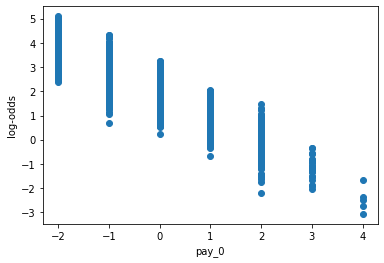

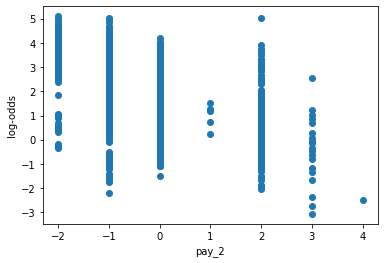

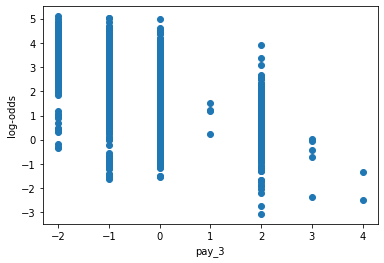

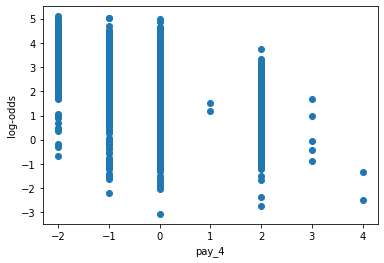

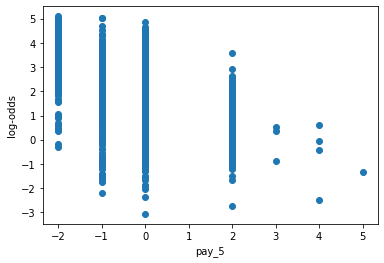

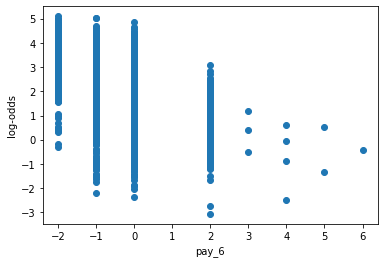

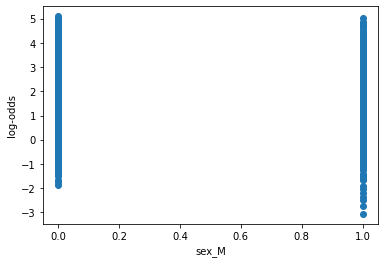

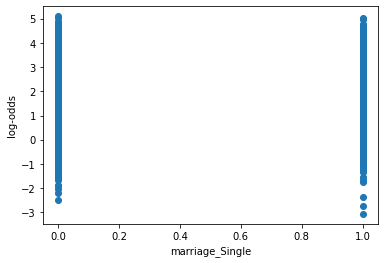

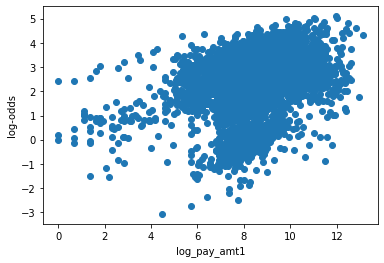

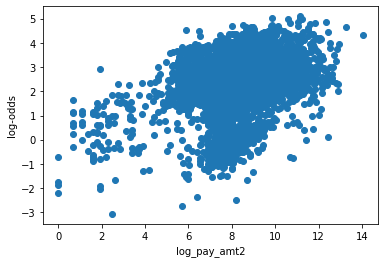

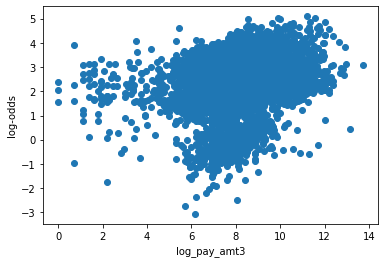

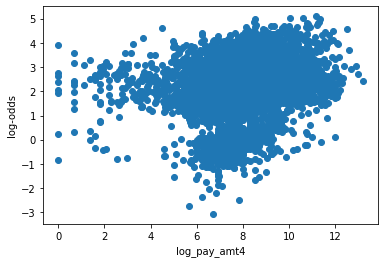

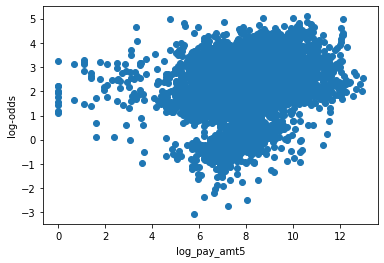

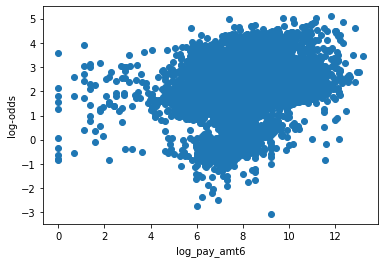

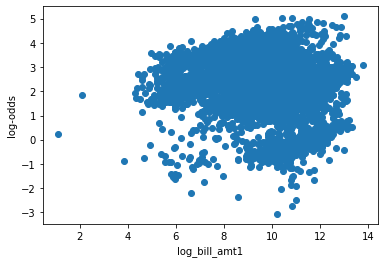

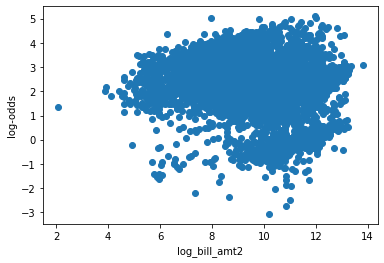

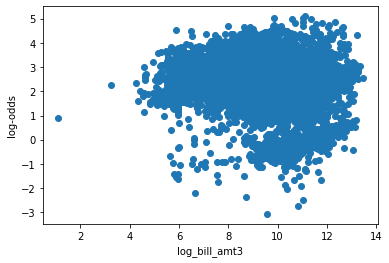

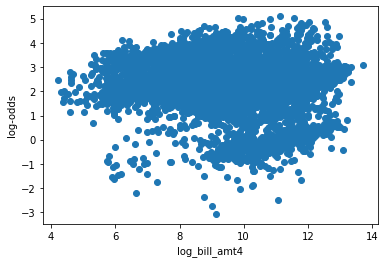

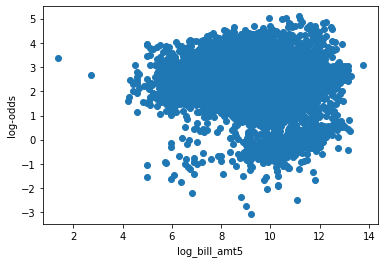

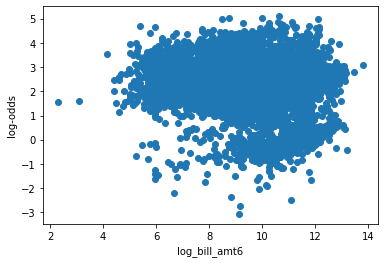

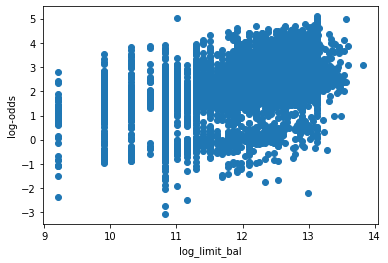

In [141]:
''' Plot again after transformations '''

X_cnst = sm.add_constant(X_train)
# Fit model and get predicted y values
lm_num = sm.GLM(y_train, X_cnst, family=sm.families.Binomial(), missing="drop").fit()
predicted = lm_num.predict(X_cnst)

# Calculated log-odds and add it to X_num
log_odds = np.log(predicted / (1 - predicted))

# Create plots of each predictor vs. log-odds
for var in X_cnst.columns.values:
    plt.scatter(x=X_cnst[var].values, y=log_odds)
    plt.xlabel(var)
    plt.ylabel("log-odds")
    plt.show()

In [142]:
''' Assumption Check #3: Identify influential outliers '''

# Calculate Cook's Distance and set threshold
influence = lm_num.get_influence()
sum_df = influence.summary_frame()
diagnosis_df = sum_df[["cooks_d"]]
cook_threshold = 4 / (X_cnst.shape[0])

# Append absolute standardized residual values 
diagnosis_df['std_resid'] = stats.zscore(lm_num.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]

# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False)

,cooks_d,std_resid
13771,0.006299,4.047464
21048,0.005607,3.550662
10347,0.005387,3.406028
21671,0.004560,3.181228
17866,0.004532,4.767460
...,...,...
15513,0.000182,3.078713
28751,0.000181,3.145138
1408,0.000178,3.335298
1130,0.000178,3.069802


In [143]:
''' Remove influential outliers '''

inf_out = extreme.index.tolist()

X_train = X_train.loc[~X_train.index.isin(inf_out), :]
y_train = y_train.loc[~y_train.index.isin(inf_out)]

In [144]:
''' Assumption Check #4: Determine collinear variables with VIF '''
from toms_custom_functions import calculate_vif

X_vif = X_train.dropna()
calculate_vif(X_vif, 10)

,variables,VIF
18,log_bill_amt3,550.790441
19,log_bill_amt4,534.891242
17,log_bill_amt2,523.420658
20,log_bill_amt5,514.379809
21,log_bill_amt6,386.917334
16,log_bill_amt1,243.404114
11,log_pay_amt2,164.461638
10,log_pay_amt1,162.910553
22,log_limit_bal,145.700773
12,log_pay_amt3,131.837487


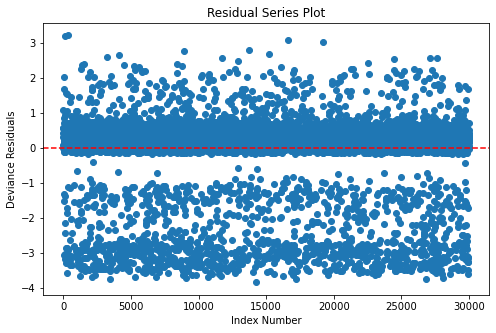

In [145]:
''' Assumption check #5: Verify independence of observations with residual series plot '''

X_cnst = sm.add_constant(X_train)

# Fit model and get predicted y values
lm_int = sm.GLM(y_train, X_cnst, family=sm.families.Binomial(), missing="drop").fit()

# Setup plot 
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
                     xlabel="Index Number", 
                     ylabel="Deviance Residuals")

# Generate residual series plot using standardized deviance residuals
ax.scatter(X_cnst.dropna().index.tolist(), stats.zscore(lm_int.resid_deviance))

# Draw horizontal line at y=0
plt.axhline(y = 0, ls="--", color='red');

In [146]:
''' Fit the model and display the summary '''

X_num = sm.add_constant(X_train)

# Set up final dfs and fit model
lm_final = sm.GLM(y_train, X_num, family=sm.families.Binomial(), missing="drop").fit()

print(lm_final.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                11381
Model:                            GLM   Df Residuals:                    11357
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3194.0
Date:                Mon, 24 Oct 2022   Deviance:                       6388.1
Time:                        22:57:10   Pearson chi2:                 9.55e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.9075      0.495    -

Accuracy score: 87.31%
Recall: 97.84%
Precision: 88.52%
F1 Score: 92.95%


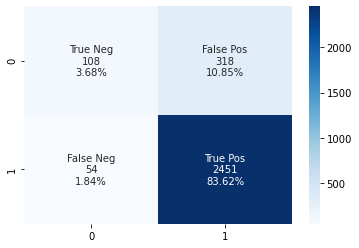

In [147]:
''' Make prediction on test set'''

lm = LogisticRegression()

X_reg = X_train.dropna()

lm.fit(X_reg, y_train[X_reg.index.values])

X_val = X_test.dropna()
predictions = lm.predict(X_val)

y_val = y_test[X_val.index.values]

cf_matrix = confusion_matrix(y_val, predictions)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

accuracy_score = "{0:.2%}".format(accuracy_score(y_val, predictions))
recall = "{0:.2%}".format(recall_score(y_val, predictions))
precision = "{0:.2%}".format(precision_score(y_val, predictions))
f1_score = "{0:.2%}".format(f1_score(y_val, predictions))
print(f"Accuracy score: {accuracy_score}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")

In [ ]:
# To-do:
# 1. Clean up code and apply functions